In [ ]:
###   Rede Neural Multi-Modal Perception   ###

In [ ]:
###   Importa os arquivos a serem utilizados nesta implementação   ###

#from google.colab import files
#files.upload()

In [ ]:
###   Instala a biblioteca tensorflow_docs   ###

# pip install git+https://github.com/tensorflow/docs

In [7]:
pip install git+https://github.com/tensorflow/docs


  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ggex14kh
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ggex14kh
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.03082041fb5ef2b29217584659bc43d89602d57cf_-cp36-none-any.whl size=101669 sha256=e8a022da4e2ed86624c8dbd7eee505723ce131bcccd64e96d94ec1adeab4b93d
  Stored in directory: /tmp/pip-ephem-wheel-cache-pzw_ubzx/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [8]:
###   Importação de bibliotecas   ###

import tensorflow as tf
import supercon_dados as tsd
import supercon_funcoes_apoio_ML as tsf
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn import preprocessing
from sklearn.cluster import KMeans
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import matplotlib.pyplot as plt


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
###   Verifica se há acesso à GPU   ###


device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [10]:
#versão do tensorflow
print(tf.__version__)

2.2.0


In [ ]:
###   Divisão dos dados que serão usados em um processão de validação cruzada para obtenção de melhores parâmetros    ###

X_treino, X_teste, Y_treino, Y_teste = tsf.divisao_dados_treinamento(0.2,tsd.X_modelagem,tsd.Y_modelagem)

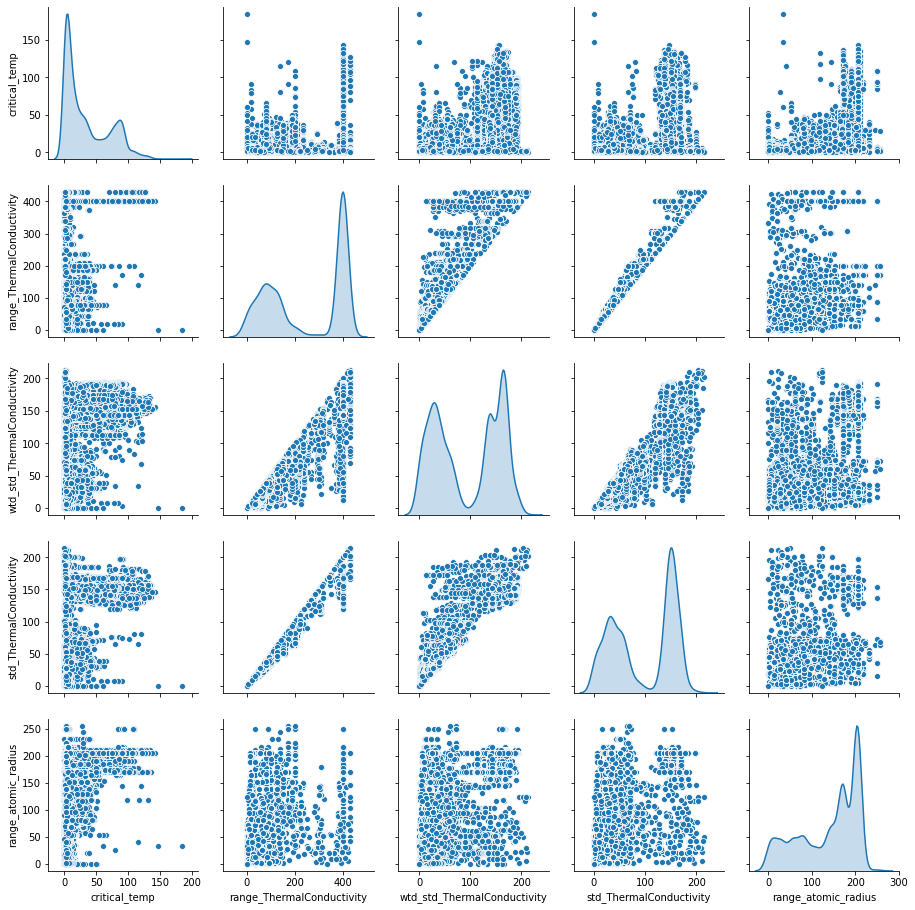

In [12]:
###   Visualização de alguns parâmetros relevantes e as temperaturas críticas  ###

sns.pairplot(tsd.base_geral[['critical_temp','range_ThermalConductivity', 'wtd_std_ThermalConductivity',
       'std_ThermalConductivity', 'range_atomic_radius']], diag_kind="kde")

In [13]:
###   Normalização dos dados de treino   ###

scaler = preprocessing.StandardScaler()
scaler.fit(X_treino)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [14]:
#ver as dimensões do Frame X_treino
X_treino.shape

(17231, 81)

In [ ]:
#Conjunto de treino normalizado
X_treino_N = pd.DataFrame(data = scaler.transform(X_treino),columns = X_treino.columns, index = X_treino.index)

In [ ]:
#Conjunto de teste normalizado
X_teste_N = pd.DataFrame(data = scaler.transform(X_teste),columns = X_teste.columns, index = X_teste.index)

In [ ]:
###   Explorações de cenários para determinação dos melhores hiperparâmetros do modelo   ###  

In [18]:
#Situação 1

# Arquitetura da rede neural usando Keras (número de camadas e números de neurônios)

def build_model1():

  model1 = keras.Sequential([
    layers.Dense(41, activation='relu', input_shape=[len(X_treino_N.columns)]),
    layers.Dense(21, activation='relu'),
    layers.Dense(1)
  ])

  # Otimizados da função Loss (redução do MSE)

  optimizer = tf.keras.optimizers.Adam(0.001)

  model1.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model1


# Instanciando o modelo
model1 = build_model1()
# Visualização da arquitetura do modelo
model1.summary()

# Armazenamento de dados sobre os hiperparâmetros
gravacao1_t1 =[]
gravacao1_erro =[]
gravacao1_r2 = []

teste1 = [32,64,128]

for t1 in teste1:

  gravacao1_t1.append(t1)

  # Uso da GPU

  with tf.device('/device:GPU:0'):


    # Instanciando o modelo

    model1 = build_model1()

    # Número máximo de etapas (cada etapa corresponde a passagem de todos os dados na rede neural)
    EPOCHS=1000

    # Incorpora a parada antecipado no treinamento do modelo, representa o ponto onde o modelo para de reduzir o rms e auumenta a chance de overfitting
    early_stop1 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

    # Treina o modelo
    early_history1 = model1.fit(X_treino_N, Y_treino,batch_size=t1,
                        epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                        callbacks=[early_stop1, tfdocs.modeling.EpochDots()])
    
    # Usa o modelo treinado para prediçao 
    lista_predicao1 = model1.predict(X_teste_N).flatten()

    gravacao1_erro.append(np.sqrt(mean_squared_error(lista_predicao1, Y_teste)))   

    gravacao1_r2.append(r2_score(lista_predicao1, Y_teste))       



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 41)                3362      
_________________________________________________________________
dense_1 (Dense)              (None, 21)                882       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 22        
Total params: 4,266
Trainable params: 4,266
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:666.1340,  mae:16.8545,  mse:666.1340,  val_loss:331.8178,  val_mae:13.0630,  val_mse:331.8178,  
....................................................................................................
Epoch: 100, loss:136.6354,  mae:7.5937,  mse:136.6354,  val_loss:166.7901,  val_mae:8.7833,  val_mse:166.7901,  
........................................................

In [19]:
np.array([gravacao1_t1,gravacao1_erro,gravacao1_r2])

array([[ 32.        ,  64.        , 128.        ],
       [ 11.3084362 ,  11.21102721,  11.634958  ],
       [  0.8836047 ,   0.88032415,   0.86724277]])

In [20]:
#Situação 2

def build_model2():

  model2 = keras.Sequential([
    layers.Dense(61, activation='relu', input_shape=[len(X_treino_N.columns)]),
    layers.Dense(41, activation='relu'),
    layers.Dense(21, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model2.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model2



model2 = build_model2()
model2.summary()

gravacao2_t2 =[]
gravacao2_erro =[]
gravacao2_r2 = []

teste2 = [32,64,128]

for t2 in teste2:

  gravacao2_t2.append(t2)

  with tf.device('/device:GPU:0'):

    model2 = build_model2()

    EPOCHS=1000

    
    early_stop2 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

    early_history2 = model2.fit(X_treino_N, Y_treino,batch_size=t2,
                        epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                        callbacks=[early_stop2, tfdocs.modeling.EpochDots()])
    
    # model2.evaluate(X_teste_N, Y_teste, verbose=2)

    lista_predicao2 = model2.predict(X_teste_N).flatten()

    gravacao2_erro.append(np.sqrt(mean_squared_error(lista_predicao2, Y_teste)))   

    gravacao2_r2.append(r2_score(lista_predicao2, Y_teste))     

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 61)                5002      
_________________________________________________________________
dense_13 (Dense)             (None, 41)                2542      
_________________________________________________________________
dense_14 (Dense)             (None, 21)                882       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 22        
Total params: 8,448
Trainable params: 8,448
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:480.6615,  mae:14.4825,  mse:480.6615,  val_loss:282.1783,  val_mae:11.4602,  val_mse:282.1783,  
....................................................................................................
Epoch: 100, loss:103.5014,  mae:6.3

In [21]:
np.array([gravacao2_t2,gravacao2_erro,gravacao2_r2])

array([[ 32.        ,  64.        , 128.        ],
       [ 10.73233048,  10.74557582,  10.98475143],
       [  0.88714254,   0.8918174 ,   0.89051775]])

In [22]:
#Situação 3

gravacao3_t3 =[]
gravacao3_erro =[]
gravacao3_r2 = []
gravacao3_neuronio = []

neuronio_camada = [162,81,41]

for neuronio in neuronio_camada:

  def build_model3():
    
    model3 = keras.Sequential([
    layers.Dense(neuronio, activation='relu', input_shape=[len(X_treino_N.columns)]),
    layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model3.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  
    return model3



  model3 = build_model3()
  model3.summary()




  teste3 = [32,64,128]

  for t3 in teste3:

    gravacao3_neuronio.append(neuronio)

    gravacao3_t3.append(t3)

    with tf.device('/device:GPU:0'):

      model3 = build_model3()

      EPOCHS=1000

      # The patience parameter is the amount of epochs to check for improvement
      early_stop3 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

      early_history3 = model3.fit(X_treino_N, Y_treino,batch_size=t3,
                          epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                          callbacks=[early_stop3, tfdocs.modeling.EpochDots()])
      
      # model3.evaluate(X_teste_N, Y_teste, verbose=2)

      lista_predicao3 = model3.predict(X_teste_N).flatten()

      gravacao3_erro.append(np.sqrt(mean_squared_error(lista_predicao3, Y_teste)))   

      gravacao3_r2.append(r2_score(lista_predicao3, Y_teste))  


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 162)               13284     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 163       
Total params: 13,447
Trainable params: 13,447
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:588.7293,  mae:16.1726,  mse:588.7293,  val_loss:321.5981,  val_mae:12.6935,  val_mse:321.5981,  
....................................................................................................
Epoch: 100, loss:151.6365,  mae:8.1967,  mse:151.6365,  val_loss:170.2650,  val_mae:8.7828,  val_mse:170.2650,  
...................................................................................................
Epoch: 0, loss:795.7919,  mae:18.7666,  mse:795.7919,  val_loss:358.3284,  val_mae:1

In [23]:
np.array([gravacao3_neuronio,gravacao3_t3,gravacao3_erro,gravacao3_r2])

array([[162.        , 162.        , 162.        ,  81.        ,
         81.        ,  81.        ,  41.        ,  41.        ,
         41.        ],
       [ 32.        ,  64.        , 128.        ,  32.        ,
         64.        , 128.        ,  32.        ,  64.        ,
        128.        ],
       [ 12.21868112,  11.89983689,  12.23636778,  12.7278799 ,
         12.37235355,  12.7263956 ,  12.75830274,  12.73432407,
         13.20717866],
       [  0.85211474,   0.87315334,   0.85255823,   0.84683473,
          0.85234424,   0.84574338,   0.84016247,   0.84354207,
          0.84009374]])

In [ ]:
### Treinamento do modelo com a melhor arquitetura e hiperparâmetro ###

In [ ]:
def build_model():

  model = keras.Sequential([
    layers.Dense(61, activation='relu', input_shape=[len(X_treino_N.columns)]),
    layers.Dense(41, activation='relu'),
    layers.Dense(21, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [26]:
with tf.device('/device:GPU:0'):

      model = build_model()

      EPOCHS=1000
      
      early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

      early_history = model.fit(X_treino_N, Y_treino,batch_size=32,
                          epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                          callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:538.2753,  mae:15.0610,  mse:538.2753,  val_loss:281.1568,  val_mae:11.4931,  val_mse:281.1568,  
....................................................................................................
Epoch: 100, loss:100.3790,  mae:6.2797,  mse:100.3790,  val_loss:137.9342,  val_mae:7.2735,  val_mse:137.9342,  
.........................................................................................

Text(0, 0.5, 'MSE (Tc^2)')

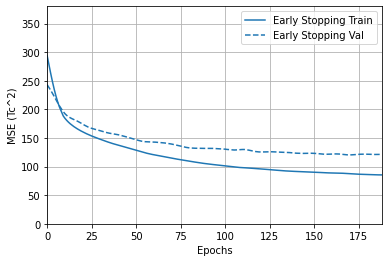

In [27]:
###  Plota a otimização que o otimizador faz sobre o RMS perante a evolução do número de etapas   ###

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Early Stopping': early_history}, metric = "mse")
plt.ylim([0, 380])
plt.ylabel('MSE (Tc^2)')

In [ ]:
#example_batch = X_treino_N[:10]
#example_result = model.predict(example_batch)
#example_result

In [ ]:
#hist = pd.DataFrame(history.history)
#hist['epoch'] = history.epoch
#hist.tail()

In [ ]:
#plotter.plot({'Basic': history}, metric = "mse")
#plt.ylim([0, 300])
#plt.ylabel('MSE [Tc (K)]')

In [31]:
### Avalia do modelo treinado ###

model.evaluate(X_teste_N, Y_teste, verbose=2)

135/135 - 0s - loss: 117.3152 - mae: 6.7674 - mse: 117.3152


[117.31517028808594, 6.767434597015381, 117.31517028808594]

In [32]:
###   Imprime o resultado dos dados treinados   ###

print('\n R^2: \n', r2_score(model.predict(X_treino_N).flatten(), Y_treino) , '\n RMSE : \n',np.sqrt(mean_squared_error(model.predict(X_treino_N).flatten(), Y_treino))) 


 R^2: 
 0.9137684205325759 
 RMSE : 
 9.506038229863975


In [33]:
###   Imprime o resultado dos dados nunca treinados   ###

print('\n R^2: \n', r2_score(model.predict(X_teste_N).flatten(), Y_teste) , '\n RMSE : \n',np.sqrt(mean_squared_error(model.predict(X_teste_N).flatten(), Y_teste))) 


 R^2: 
 0.8895180118753684 
 RMSE : 
 10.831214000981044


In [34]:
# mínimo de predição para os dados de treino

min(model.predict(X_treino_N).flatten())

-17.803177

In [35]:
# mínimo de predição para os dados de teste

min(model.predict(X_teste_N).flatten())

-9.487807

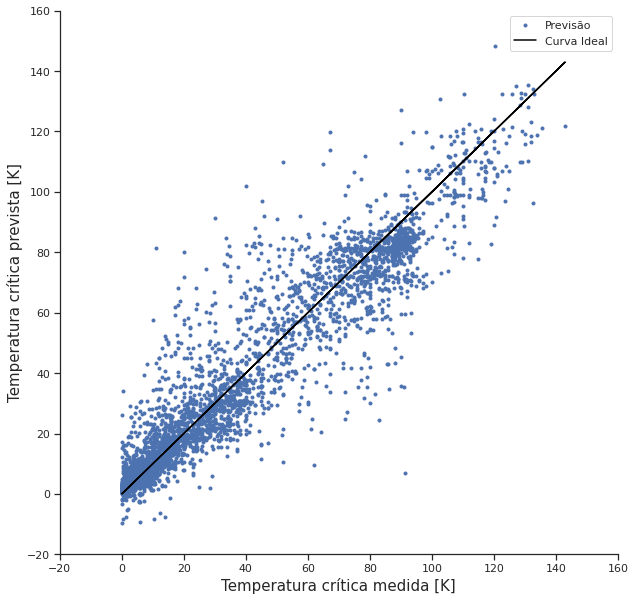

In [40]:
###   Visualização dos resultados de treinamento sobre dados nunca treinados pelo modelo   ###


print_x = Y_teste
print_y = model.predict(X_teste_N).flatten()

f, ax = plt.subplots(figsize=(10, 10))

sns.set(style="ticks")
sns.despine()
plt.plot(print_x,print_y, 'b.',label = 'Previsão')
plt.plot(print_x,print_x, '-', label = 'Curva Ideal', color = 'black')
plt.xlabel('Temperatura crítica medida [K]',fontsize = 15)
plt.ylabel('Temperatura crítica prevista [K]',fontsize = 15)
plt.legend()
plt.xticks(np.linspace(-20, 160, 10, endpoint=True))
plt.yticks(np.linspace(-20, 160, 10, endpoint=True))
plt.axis([-20,160,-20,160])

plt.show()